In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skopt import gp_minimize
from skopt.plots import plot_convergence,plot_gaussian_process
from skopt.space import Integer
from skopt.utils import use_named_args
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading the dataset
x_breast,y_breast=load_breast_cancer(return_X_y=True)
x=pd.DataFrame(x_breast)
y=pd.Series(y_breast).map({0:1,1:0})
x.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
#Percentage of the benign and the malign tumour
y.value_counts()/len(y)

0    0.627417
1    0.372583
dtype: float64

In [4]:
#Splitting the dataset into train and test
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)
print(x_train.shape)
print(x_test.shape)

(398, 30)
(171, 30)


# Determine the hyperparameter response function

for 1 parameter the number of estimators

In [6]:
#Set up the model
gbm=GradientBoostingClassifier(random_state=0)
#Determine the hyperparameter space
param_grid={
    'n_estimators':[10,20,50,100,120,150,200,250,300],
    
}
#set up the search
search=GridSearchCV(gbm,param_grid=param_grid,scoring='accuracy',cv=3,refit=False)
#Find the best hyperparameter
search.fit(x_train,y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=0),
             param_grid={'n_estimators': [10, 20, 50, 100, 120, 150, 200, 250,
                                          300]},
             refit=False, scoring='accuracy')

In [7]:
results=pd.DataFrame(search.cv_results_)
results.sort_values(by='param_n_estimators',ascending=False,inplace=True)
results[['param_n_estimators','mean_test_score','std_test_score']]

,param_n_estimators,mean_test_score,std_test_score
8,300,0.952286,0.014111
7,250,0.952286,0.014111
6,200,0.952286,0.014111
5,150,0.949780,0.012687
4,120,0.949761,0.012736
3,100,0.947236,0.012280
2,50,0.942223,0.018721
1,20,0.934685,0.012722
0,10,0.937210,0.009236


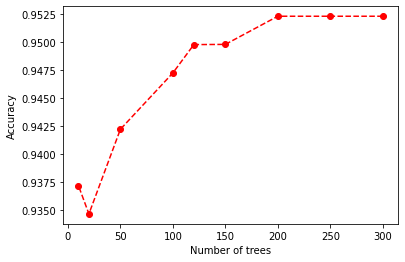

In [8]:
#plot f(x)-- 1-D hyperparameter space
plt.plot(results['param_n_estimators'],results['mean_test_score'],"ro--")
plt.ylabel('Accuracy')
plt.xlabel("Number of trees")
plt.show()

# Define the hyperparameter space

In [10]:
Integer(10,300,name='n_estimators')

Integer(low=10, high=300, prior='uniform', transform='identity')

In [11]:
#Specify the hyperparameter space
param_grid=[Integer(10,300,name='n_estimators')]
#Scikit optimize parameter grid is list
type(param_grid)

list

In [12]:
param_grid

[Integer(low=10, high=300, prior='uniform', transform='identity')]

# Define the objective function

In [14]:
@use_named_args(param_grid)
def objective(**param):
    #model with new parameter
    gbm.set_params(**param)
    
    value=np.mean(cross_val_score(gbm,x_train,y_train,n_jobs=-4,scoring='accuracy',cv=3))
    #negate beacuse we want to minimize
    return -value

# Bayesian optimization

In [15]:
#gp_minimmize performs by default Gp optimization
gp=gp_minimize(
objective,
param_grid,
n_initial_points=2,
n_calls=20,
acq_func='EI',
random_state=0,)

In [17]:
#Function value at the minimum
print("Best Score:{:.2f}".format(gp.fun))

Best Score:-0.95


In [18]:
print("Best Parameter:{:.2f}".format(gp.x[0]))

Best Parameter:255.00


# Evaluate convergence of the search

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

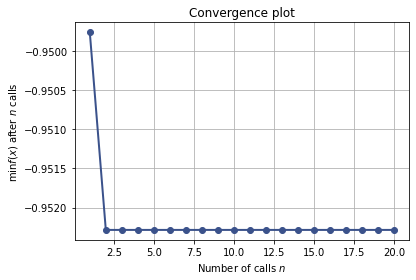

In [19]:
plot_convergence(gp)

# Plot the bayesian optimization search

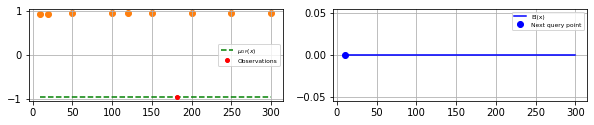

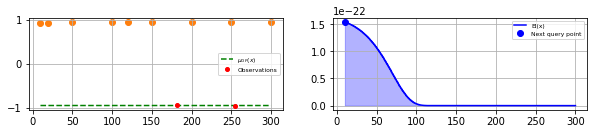

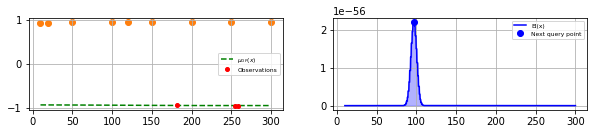

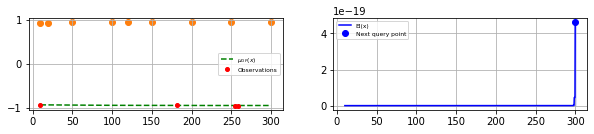

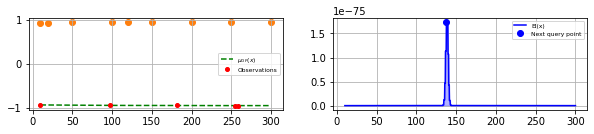

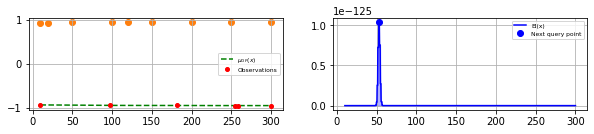

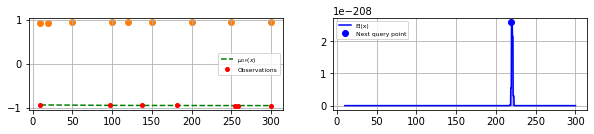

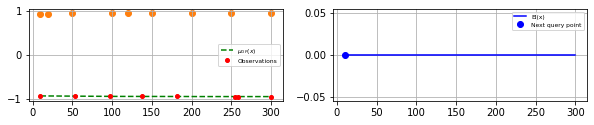

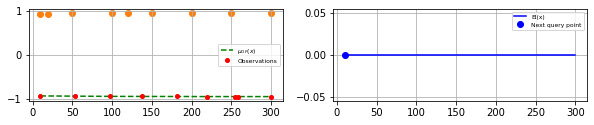

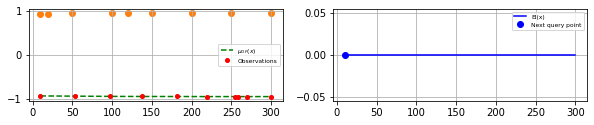

In [23]:
end=10
for n_iter in range(end):
    plt.figure(figsize=(10,20))
    
    plt.subplot(end,2,2*n_iter+1)
    #Plot the gaussian process search
    ax=plot_gaussian_process(gp,n_calls=n_iter,
                            show_legend=True,
                            show_title=False,
                            show_next_point=False,
                            show_acq_func=False)
    #Plot true hyperparameter space
    ax.scatter(results['param_n_estimators'],results['mean_test_score'])
    ax.set_ylabel("")
    ax.set_xlabel("")
    #____________________________
    plt.subplot(end,2,2*n_iter+2)
    
    ax=plot_gaussian_process(gp,
                            n_calls=n_iter,
                            show_legend=True,
                            show_title=False,
                            show_mu=False,
                            show_acq_func=True,
                            show_observations=False,
                            show_next_point=True)
    ax.set_ylabel("")
    ax.set_xlabel("")
plt.show()